## Linear Modeling Analysis

This notebook assumes a linear relationship between RTT and distance, dervies a model for determining distance given RTT, and looks at the errors in that model. It examines Atlas and MONROE data separately.

First, some needful imports and magic, followed by load from the HDF5 store that the dataprep notebooks produced.

In [32]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math
import os.path

from collections import namedtuple

import warnings
warnings.filterwarnings("ignore") 

In [33]:
ATLAS_STORE_PATH="atlas_20171002.hdf5"

with pd.HDFStore(ATLAS_STORE_PATH) as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    atlas_rtt_df = store['rtt_df']
    atlas_min_df = store['min_df']
    
with pd.HDFStore('monroe.hdf5') as store:
    monroe_min_df = store['monroe_rtt_df']

In [34]:
PLOT_PATH="../plots"

### Calculate ground truth and RTT-derived distance

For ground truth distance, we assume that the Earth is a 6371 km sphere. For RTT-derived distance, we assume that the Internet is made of fiber with an index of refraction of 1.4677.

In [35]:
EARTH_RADIUS = 6371 # radius of Earth in kilometers
c = 299792458 # speed of light in meters per second
FIBER_REFRACTION = 1.4677 # assume Corning glass is typical

SRL_LON = 13.582207 # Only one anchor for MONROE, and it's in Norway
SRL_LAT = 59.406320

def calc_ground_distance(df, alon = None, alat = None):
    
    if alon is None:
        alon = df['alon']
        
    if alat is None:
        alat = df['alat']
    
    df['tmp_aphi'] = (90.0 - alat) * math.pi/180.0
    df['tmp_pphi'] = (90.0 - df['plat']) * math.pi/180.0
    df['tmp_atheta'] = alon * math.pi/180.0
    df['tmp_ptheta'] = df['plon'] * math.pi/180.0
    df['tmp_cos'] = ( np.sin(df['tmp_aphi']) * np.sin(df['tmp_pphi']) * 
                          np.cos(df['tmp_atheta'] - df['tmp_ptheta']) + 
                          np.cos(df['tmp_aphi']) * np.cos(df['tmp_pphi']) )
    df['km'] = np.arccos(df['tmp_cos']) * EARTH_RADIUS
    del df['tmp_aphi']
    del df['tmp_pphi']
    del df['tmp_atheta']
    del df['tmp_ptheta']
    del df['tmp_cos']

def calc_exclusion_radii(df):
    # strict
    df['c_km'] = (c / 1e6) * (df['minrtt'] / 2)
    # fiber assumption
    df['fiber_km'] = ((c / 1e6) / FIBER_REFRACTION) * (df['minrtt'] / 2)

In [36]:
calc_ground_distance(atlas_min_df)
calc_exclusion_radii(atlas_min_df)

In [37]:
calc_ground_distance(monroe_min_df, alon = SRL_LON, alat = SRL_LAT)
calc_exclusion_radii(monroe_min_df)

Feed the minimum dataframes back into the data store, so we can use them in the geolocation by exclusion notebook.

In [38]:
with pd.HDFStore(ATLAS_STORE_PATH) as store:
    store['min_df'] = atlas_min_df

with pd.HDFStore('monroe.hdf5') as store:
    store['min_df'] = monroe_min_df

## Linear Model

In [39]:
def plot_linfit_rtt_by_dist(df, use_log=True, figsize=(12,8), label="all pairs", rtt_max=None):
    """
    Show a hexbin plot of correlating minumum RTT with ground truth distance 
    """
    plt.figure(figsize=figsize)
    
    if rtt_max:
        plot_df = df[df['minrtt'] < rtt_max]
    else:
        plot_df = df
    
    x = plot_df['km']
    y = plot_df['minrtt']
    if use_log:
        plt.hexbin(x, y, cmap="Greys", bins="log")
    else:
        plt.hexbin(x, y, cmap="Greys")
    plt.colorbar()
    plt.xlabel("distance (km)")
    plt.ylabel("rtt (ms)")
    if rtt_max is not None:
        plt.ylim(0, rtt_max)

    (slope, intercept, r, p, e) = scipy.stats.linregress(df['km'],df['minrtt'])
    plt.plot(x, slope * x + intercept)
    
#     if use_log:
#         scaletitle = "log10 count"
#     else:
#         scaletitle = "count"
#     plt.title("RTT by distance for {0} ({1}, r-value {2:.2f})".format(label, scaletitle, r))
    
    return (slope, intercept, r)

def calc_lin_estimate(df, linm, linb):
    df['lin_km'] = (df['minrtt'] - linb) / linm

def ecdf(ser):
    ser = ser.sort_values()
    cdf = np.linspace(0.,1.,len(ser))
    return pd.Series(cdf, index=ser)
  
def plot_linmodel_errors(df, xlim=2, alpha=0.33, thingname='anchor'):
    # iterate over anchors/probes to draw light grey lines
    xid_list = df.index.levels[0].sort_values().values
    plt.figure(figsize=(12,8))
    for xid in xid_list:
        xmin_df = df.loc[xid]
        plt.plot(ecdf(np.abs(xmin_df['km'] - xmin_df['lin_km']) / xmin_df['km']), 'k', alpha=alpha)
    # draw whole linear error in red
    plt.plot(ecdf(np.abs(df['km'] - df['lin_km']) / df['km']), 'r')
    plt.xlim(0,xlim)
    plt.ylim(0,1)
    plt.xlabel("Relative distance error")
    plt.ylabel("Empirical CDF")
    plt.title("Relative error in linear model by {}".format(thingname))
    
    return ecdf(np.abs(df['km'] - df['lin_km']) / df['km'])

#### Linear model for all Atlas pairs

Here we exclude all measurements where probe and anchor are less than 500m away from each other, to attempt to measure Internet RTT only.

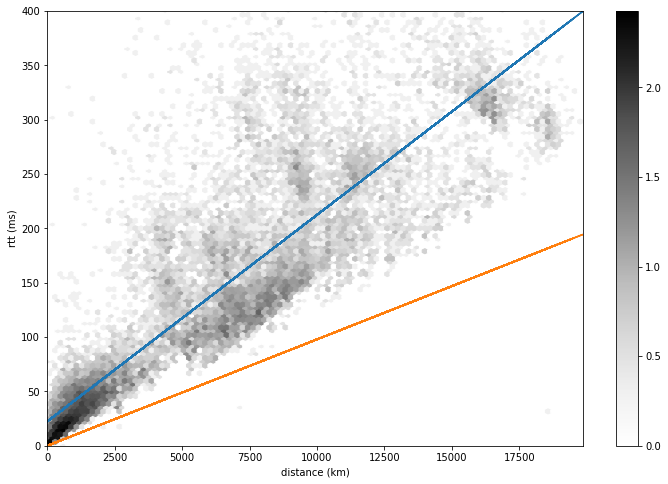

In [40]:
atlas_min_df = atlas_min_df[atlas_min_df['km'] > 0.5]

(atlas_linm, atlas_linb, atlas_linr) = plot_linfit_rtt_by_dist(atlas_min_df,rtt_max=400,label="Atlas")
plt.plot(atlas_min_df['km'], atlas_min_df['km'] * 2e6 * FIBER_REFRACTION / c)

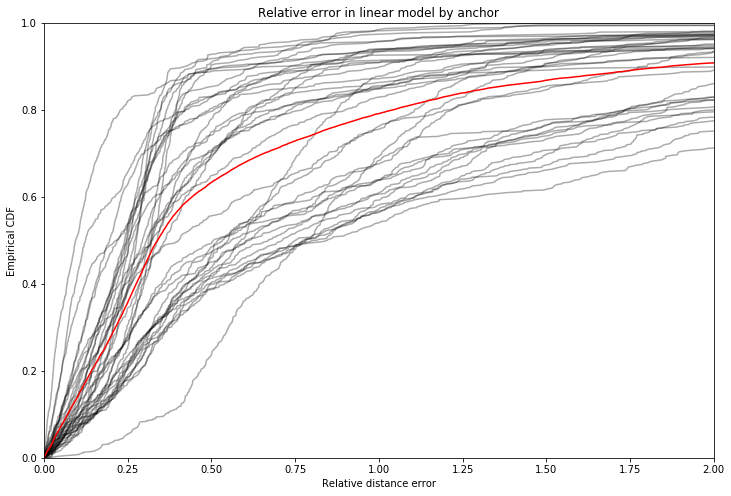

In [41]:
calc_lin_estimate(atlas_min_df, atlas_linm, atlas_linb)
atlas_all_rel_error = plot_linmodel_errors(atlas_min_df)

#### Linear model for small-RTT Atlas data

In [42]:
atlas_fastmin_df = atlas_min_df[atlas_min_df['minrtt'] < 50.0]

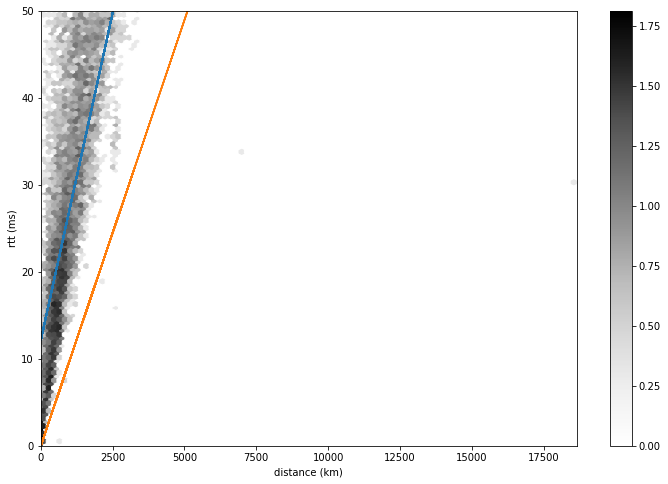

In [43]:
(atlas_fast_linm, atlas_fast_linb, atlas_fast_linr) = plot_linfit_rtt_by_dist(atlas_fastmin_df, rtt_max=50, label="Atlas RTT < 50ms")
plt.plot(atlas_fastmin_df['km'], atlas_fastmin_df['km'] * 2e6 * FIBER_REFRACTION / c)

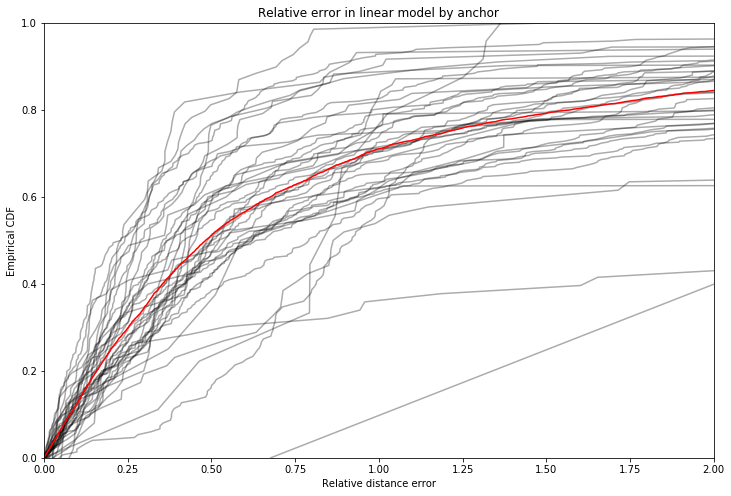

In [44]:
calc_lin_estimate(atlas_fastmin_df, atlas_fast_linm, atlas_fast_linb)
atlas_fast_rel_error = plot_linmodel_errors(atlas_fastmin_df)

#### Linear model for short-path Atlas data

In [45]:
atlas_shortmin_df = atlas_min_df[atlas_min_df['minhops'] <= 6]

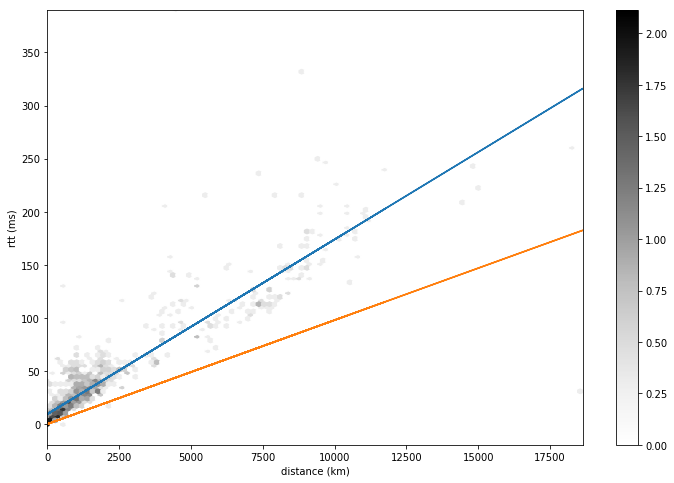

In [46]:
(atlas_short_linm, atlas_short_linb, atlas_short_linr) = plot_linfit_rtt_by_dist(atlas_shortmin_df)
plt.plot(atlas_shortmin_df['km'], atlas_shortmin_df['km'] * 2e6 * FIBER_REFRACTION / c)

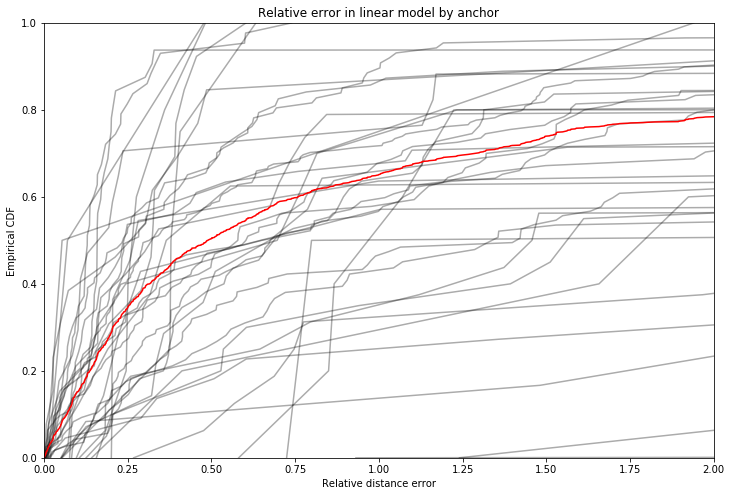

In [47]:
calc_lin_estimate(atlas_shortmin_df, atlas_short_linm, atlas_short_linb)
atlas_short_rel_error = plot_linmodel_errors(atlas_shortmin_df)

#### Linear model for all Monroe data

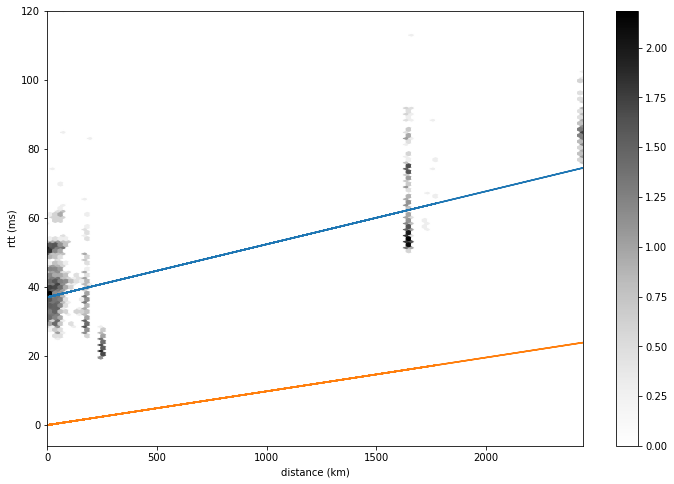

In [48]:
(monroe_linm, monroe_linb, monroe_linr) = plot_linfit_rtt_by_dist(monroe_min_df)
plt.plot(monroe_min_df['km'], monroe_min_df['km'] * 2e6 * FIBER_REFRACTION / c)

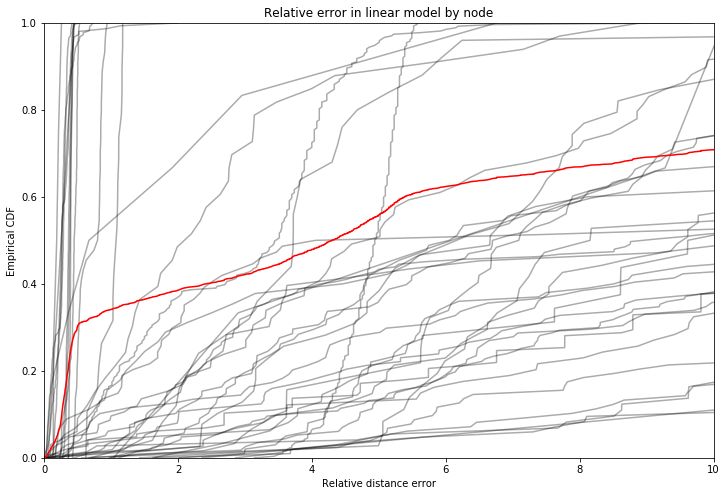

In [49]:
calc_lin_estimate(monroe_min_df, monroe_linm, monroe_linb)
monroe_rel_error = plot_linmodel_errors(monroe_min_df, thingname="node", xlim=10)

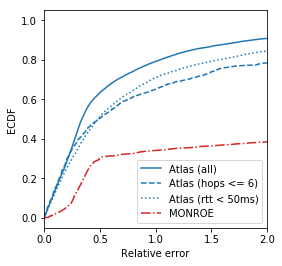

In [50]:
plt.figure(figsize=(4,4))
plt.plot(atlas_all_rel_error, 
        label="Atlas (all)", linestyle="solid", color="#1f77b4")
plt.plot(atlas_short_rel_error,
        label="Atlas (hops <= 6)", linestyle="--", color="#1f77b4")
plt.plot(atlas_fast_rel_error,          
         label="Atlas (rtt < 50ms)", linestyle=":", color="#1f77b4")
plt.plot(monroe_rel_error, 
         label="MONROE",linestyle="-.", color="#d62728")
plt.xlim(0,2)
plt.ylabel("ECDF")
plt.xlabel("Relative error")
plt.legend()
plt.savefig(os.path.join(PLOT_PATH, "linerror_rel.pdf"))


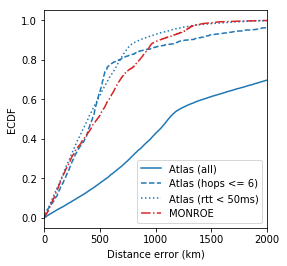

In [51]:
plt.figure(figsize=(4,4))
plt.plot(ecdf(np.abs(atlas_min_df['km'] - atlas_min_df['lin_km'])), 
         label="Atlas (all)", linestyle="solid", color="#1f77b4")
plt.plot(ecdf(np.abs(atlas_shortmin_df['km'] - atlas_shortmin_df['lin_km'])), 
         label="Atlas (hops <= 6)", linestyle="--", color="#1f77b4")
plt.plot(ecdf(np.abs(atlas_fastmin_df['km'] - atlas_fastmin_df['lin_km'])), 
         label="Atlas (rtt < 50ms)", linestyle=":", color="#1f77b4")
plt.plot(ecdf(np.abs(monroe_min_df['km'] - monroe_min_df['lin_km'])), 
         label="MONROE",linestyle="-.", color="#d62728")
plt.xlim(0,2000)
plt.ylabel("ECDF")
plt.xlabel("Distance error (km)")
#plt.title("Error in linear model estimate by dataset")
plt.legend()
plt.savefig(os.path.join(PLOT_PATH, "linerror_abs.pdf"))


rtt = 0.0190d + 22.3317; r=0.8686


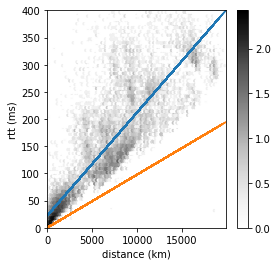

In [52]:
(atlas_linm, atlas_linb, atlas_linr) = plot_linfit_rtt_by_dist(atlas_min_df,rtt_max=400,figsize=(4,4))
plt.plot(atlas_min_df['km'], atlas_min_df['km'] * 2e6 * FIBER_REFRACTION / c)
plt.savefig(os.path.join(PLOT_PATH, "atlasmodel.pdf"))
print("rtt = {0:.4f}d + {1:.4f}; r={2:.4f}".format(atlas_linm, atlas_linb, atlas_linr))

rtt = 0.0165d + 9.3563; r=0.9006


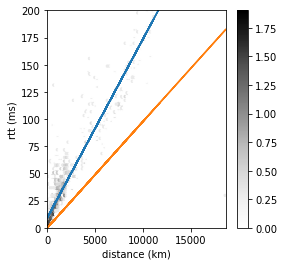

In [53]:
(atlas_short_linm, atlas_short_linb, atlas_short_linr) = plot_linfit_rtt_by_dist(atlas_shortmin_df,rtt_max=200,figsize=(4,4))
plt.plot(atlas_shortmin_df['km'], atlas_shortmin_df['km'] * 2e6 * FIBER_REFRACTION / c)
plt.savefig(os.path.join(PLOT_PATH, "atlasshortmodel.pdf"))
print("rtt = {0:.4f}d + {1:.4f}; r={2:.4f}".format(atlas_short_linm, atlas_short_linb, atlas_short_linr))

rtt = 0.0154d + 37.0375; r=0.7808


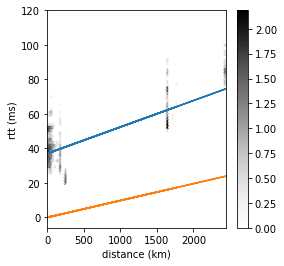

In [76]:
(monroe_linm, monroe_linb, monroe_linr) = plot_linfit_rtt_by_dist(monroe_min_df,figsize=(4,4))
plt.plot(monroe_min_df['km'], monroe_min_df['km'] * 2e6 * FIBER_REFRACTION / c)
plt.savefig(os.path.join(PLOT_PATH, "monroemodel.pdf"))
print("rtt = {0:.4f}d + {1:.4f}; r={2:.4f}".format(monroe_linm, monroe_linb, monroe_linr))

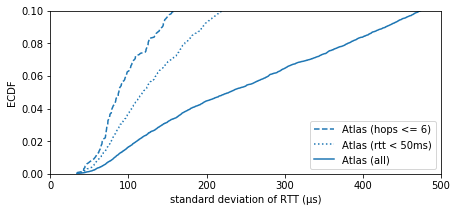

In [63]:
plt.figure(figsize=(7,3))
plt.plot(ecdf(atlas_shortmin_df['rttstd']*1000), 
         label="Atlas (hops <= 6)", linestyle="--", color="#1f77b4")
plt.plot(ecdf(atlas_fastmin_df['rttstd']*1000),
         label="Atlas (rtt < 50ms)", linestyle=":", color="#1f77b4")
plt.plot(ecdf(atlas_min_df['rttstd']*1000),
         label="Atlas (all)", linestyle="solid", color="#1f77b4")
# plt.plot(ecdf(monroe_min_df['rttstd']),
#          label="MONROE",linestyle="-.", color="#d62728")
plt.xlim(0,500)
plt.ylim(0,0.1)
plt.ylabel("ECDF")
plt.xlabel("standard deviation of RTT (µs)")
plt.legend()
plt.savefig(os.path.join(PLOT_PATH, "rttstd.pdf"))


In [69]:
(atlas_min_df['rttstd']*1000).quantile(0.01)

82.23625194951964

In [70]:
(atlas_fastmin_df['rttstd']*1000).quantile(0.01)

63.627352395225074

In [71]:
(atlas_shortmin_df['rttstd']*1000).quantile(0.01)

57.24765400070821

In [57]:
len(atlas_min_df)

22072

In [58]:
len(atlas_rtt_df)

9613126

In [27]:
with pd.HDFStore("monroe.hdf5") as store:
    print(len(store['ping_df']))

11537386


In [28]:
len(monroe_min_df)

3860

In [29]:
len(monroe_min_df.index.levels[0])

45